In [34]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn 
import numpy as np 
import argparse
import torch
import matplotlib.pyplot as plt
import os

In [3]:
import Torch_Pruning.torch_pruning as tp

In [2]:
class VGG(torch.nn.Module):
    def __init__(self, vgg='vgg16_bn', data_set='CIFAR10', pretrained=False):
        super(VGG, self).__init__()
        self.features = models.__dict__[vgg](pretrained=pretrained).features
        
        classifier = []
        if 'CIFAR' in data_set:
            num_class = int(data_set.split("CIFAR")[1])
            
            classifier.append(torch.nn.Linear(512, 512))
            classifier.append(torch.nn.BatchNorm1d(512))
            classifier.append(torch.nn.Linear(512, num_class))
        else:
            raise RuntimeError("Not expected data flag !!!")

        self.classifier = torch.nn.Sequential(*classifier)
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
def prune_model(model):
    model.cpu()
    DG = tp.DependencyGraph().build_dependency( model, torch.randn(1, 3, 32, 32) )
    def prune_conv(conv, amount=0.2):
        strategy = tp.strategy.L1Strategy()
        pruning_index = strategy(conv.weight, amount=amount)
        plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, pruning_index)
        plan.exec()
    
    block_prune_probs = [0.6, 0.1, 0.15, 0.1, 0.1, 0.15, 0.15, 0.2, 0.8, 0.8, 0.8, 0.4, 0.4]
    conv_id = 0
    for m in model.features:
        if isinstance( m, torch.nn.Conv2d ):
            print(conv_id, m)
            prune_conv( m, block_prune_probs[conv_id] )
            conv_id += 1
    return model

In [5]:
def get_dataloader():
    train_loader = torch.utils.data.DataLoader(
        CIFAR10('./data', train=True, transform=transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]), download=True),batch_size=256, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        CIFAR10('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
        ]),download=True),batch_size=256, num_workers=2)
    return train_loader, test_loader

In [6]:
def eval(model, test_loader):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (img, target) in enumerate(test_loader):
            img = img.to(device)
            out = model(img)
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)
    return correct / total

In [7]:
def train_model(model, train_loader, test_loader, epochs, round_num):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 70, 0.1)
    model.to(device)
    acc_s = []
    best_acc = -1
    for epoch in range(epochs):
        model.train()
        for i, (img, target) in enumerate(train_loader):
            img, target = img.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = F.cross_entropy(out, target)
            loss.backward()
            optimizer.step()
        model.eval()
        acc = eval(model, test_loader)
        acc_s.append(acc)
        if best_acc<acc:
            torch.save( model, 'resnet18-round%d.pth'%(round_num) )
            best_acc=acc
        scheduler.step()
    return best_acc, np.mean(acc_s)

In [8]:
train_loader, test_loader = get_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
model = VGG('vgg16_bn', 'CIFAR10')

In [10]:
params = sum([np.prod(p.size()) for p in model.parameters()])
print("Number of Parameters: %.1fM"%(params/1e6))

Number of Parameters: 15.0M


In [11]:
model_dict = {
    'params': [],
    'summary': [],
    'best_acc': [],
    'mean_acc': [],
    'out_channels': [],
    'size': []
}

In [12]:
for i in range(5):
    print(f'--- Round {i} ---')
    if i > 0:
        model = prune_model(model)
    params = sum([np.prod(p.size()) for p in model.parameters()])
    print("Number of Parameters: %.1fM"%(params/1e6))
    model_dict['params'].append(params/1e6)
    model_dict['summary'].append(model)
    best_acc, mean_acc = train_model(model, train_loader, test_loader, 100 if i == 0 else 30, i)
    model_dict['best_acc'].append(best_acc)
    model_dict['mean_acc'].append(mean_acc)
    
    size = os.path.getsize('resnet18-round{x}.pth'.format(x=i)) / (1024 * 1024)
    model_dict['size'].append(size)
    
    out_ch = []
    for layer in model.features:
    if isinstance(layer, torch.nn.Conv2d):
        out_ch.append(layer.weight.data.cpu().numpy().shape[0])
    model_dict['out_channels'].append(out_ch)

--- Round 0 ---
Number of Parameters: 15.0M
--- Round 1 ---
0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 Conv2d(26, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(58, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 Conv2d(109, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 Conv2d(116, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
5 Conv2d(231, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 Conv2d(218, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Conv2d(218, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 Conv2d(410, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 Conv2d(103, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10 Conv2d(103, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 Conv2d(103, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
12 Conv2d(308, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Number of Parameters: 4.0M
--- Ro

In [30]:
model_dict['best'][0], model_dict['best'][-1]

(0.9126, 0.8669)

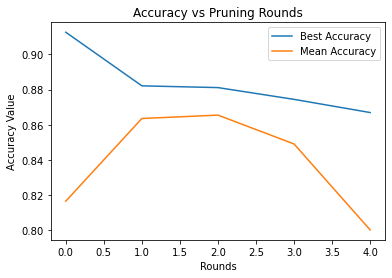

In [19]:
plt.plot(model_dict['best'], label='Best Accuracy')
plt.plot(model_dict['mean'], label='Mean Accuracy')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Accuracy Value')
plt.title('Accuracy vs Pruning Rounds')
plt.show()

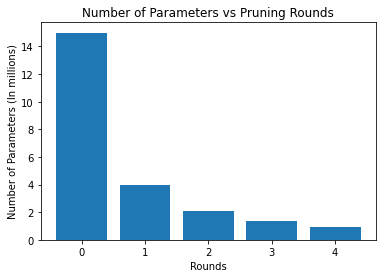

In [32]:
plt.bar(np.arange(5), model_dict['params'])
plt.xlabel('Rounds')
plt.ylabel('Number of Parameters (In millions)')
plt.title('Number of Parameters vs Pruning Rounds')
plt.show()

In [22]:
sizes = []
for i in range(5):
    
    print(f"Model Size after round {i} = " +
          f"{size:.1f} MB")

Model Size after round 0 = 57.3 MB
Model Size after round 1 = 15.3 MB
Model Size after round 2 = 7.9 MB
Model Size after round 3 = 5.1 MB
Model Size after round 4 = 3.6 MB


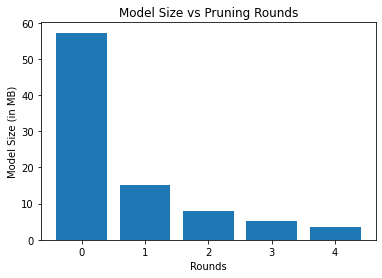

In [33]:
plt.bar(np.arange(5), sizes)
plt.xlabel('Rounds')
plt.ylabel('Model Size (in MB)')
plt.title('Model Size vs Pruning Rounds')
plt.show()